### Preliminaries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

### Coordinate detection

In [ ]:
def detect_green_dots(image_path):
    """
    Detect neon-green dots in an image using HSV thresholding + connected components.
    Returns a list of (x, y) centroids.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define HSV threshold range for neon green points
    lower_green = np.array([40, 100, 100])
    upper_green = np.array([80, 255, 255])

    # Apply threshold
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Morphological cleaning
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Connected components
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    points = []
    for i in range(1, num):  # skip background
        cx, cy = centroids[i]
        points.append((int(cx), int(cy)))

    df = pd.DataFrame(points, columns=["x0", "y0"])

    for i, (x, y) in enumerate(points, start=1):  # start=1 if you want numbering from 1 instead of 0
        # Draw a circle for the point
        cv2.circle(img, (x, y), radius=5, color=(0, 255, 0), thickness=-1)
        # Put text next to the point
        cv2.putText(img, str(i), (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (0, 0, 255), 2)

    cv2.imshow("Annotated", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return df

### 3D Recreation

In [ ]:
df1 = detect_green_dots('moreannopics/3.jpg')
df2 = detect_green_dots('moreannopics/5.jpg')

df1['x1'] = df2['x0']
df1 = df1[['y0', 'x0', 'x1']]

df1 = df1[10:40] 
df1

In [23]:
arr0 = df1['y0'].to_numpy()
arr1 = df1['x0'].to_numpy()
arr2 = df1['x1'].to_numpy()

arr0 = np.reshape(arr0, (6, 5))
arr1 = np.reshape(arr1, (6, 5))
arr2 = np.reshape(arr2, (6, 5))

In [27]:
arr1

array([[ 336,  638,  894,  210, 1004],
       [ 640,  335,  895,  638,  215],
       [1007,  338,  894,  639,  219],
       [1005,  339,  895,  637,  217],
       [1007,  340,  895,  641, 1006],
       [ 221,  342,  899,  638,  689]], dtype=int64)

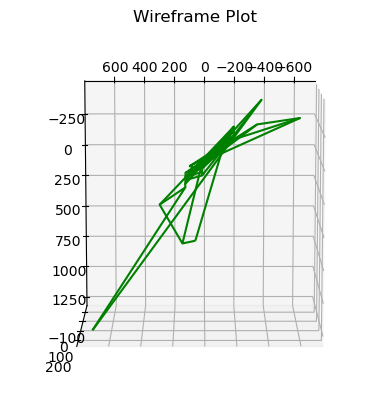

In [25]:
# focal length of camera
f = 200
# camera transverse distance
b = 100
# position of points in reference images
num_pts = 10
c = 128

# convert to numpy arrays
x1 = arr1
x2 = arr2
y = arr0
# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='green')
ax.set_title('Wireframe Plot')

ax.view_init(100, 90, 0)
plt.show()